In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#import keras
#from keras.preprocessing.text import text_to_word_sequence
#from sklearn                  import preprocessing

In [2]:
###############################################################################
# Step 1 - import data 
# Initially, subset to a small batch to see whether the process 
# I intend to implement works -e.g. working with example of numbers only
###############################################################################
folder = '~/projects/text_normalization/'
df0 = pd.read_csv(folder + 'en_train_cardinals.csv', nrows = 1000000, dtype = {'sentence_id': np.int32,
                                          'token_id'   : np.int32,
                                          'class' : str,
                                          'before': str,
                                          'after' : str})

#df0 = pd.concat(chunk for chunk in csv_chunks)
total_number_of_input_phrases           = df0.shape[0]
print('Imported ', total_number_of_input_phrases, 'records')

#review imported dataset
#print(df0.loc[9:28,['class', 'before','after']])
#print(df0.loc[number_of_input_phrases-10:number_of_input_phrases-1,['class', 'before','after']])

#Subset the original data frame to areas of interest for practice
#df = df0[df0['class'] =='CARDINAL'].reset_index() #'DIGIT', 'DECIMAL')
selected_types_set = {'CARDINAL'}
#selected_types_set = {'DIGIT','CARDINAL','ORDINAL','DECIMAL', 'FRACTION', 'MONEY', 'MEASURE', 'DATE', 'TELEPHONE', 'TIME'} 
#not_selected_types_set = {'PLAIN', 'PUNCT'} #more to be added
type_match = lambda type: type in selected_types_set
#df = df0[df0['class'].apply(type_match)==True].reset_index(drop=True)

df1 = df0[df0['class'].apply(type_match)==True].reset_index(drop=True)

# Next, focus on cardinals written with at most 10 symbols
df  = df1[df1['before'].apply(len)<=10].reset_index(drop=True)

#print(df.loc[9:28,['class', 'before','after']])

number_of_input_phrases              = df.shape[0]
print('Selected %i records out of %i for modeling.'%(number_of_input_phrases,total_number_of_input_phrases))

#df.head()
#df.shape

#Split input data into development, validation and testing data frames
#np.random.seed(217)
random.seed(217)
df['r'] = [random.uniform(0,1) for _ in df.index]
#print(df['r'])

df_train= df[ df['r'] <  0.5                     ].reset_index(drop=True)
df_val  = df[(df['r'] >= 0.5 ) & (df['r'] < 0.75)].reset_index(drop=True)
df_test = df[ df['r'] >= 0.75                    ].reset_index(drop=True)


data_size_train = df_train.shape[0]
data_size_val   = df_val.shape[0]
data_size_test  = df_test.shape[0]

print('Split selected records into ',
      '\n - training sample (%i records), '%data_size_train,
      '\n - validation sample (%i records) used to select best model candidates,'%data_size_val,
      '\n - testing sample (%i records) used to review model quality'%data_size_test)

#print(df['before'].apply(len))

Imported  133744 records
Selected 133540 records out of 133744 for modeling.
Split selected records into  
 - training sample (66565 records),  
 - validation sample (33515 records) used to select best model candidates, 
 - testing sample (33460 records) used to review model quality


In [3]:
###############################################################################
# Step 2   - Transform imported data into vector form
#      2.1 - Identify tokens that are part of the input and output vocabulary
#      ...
###############################################################################
from collections import Counter
from operator import itemgetter
DEFAULT_TOKEN = '[?]'

str_to_list_input  = lambda s: list(str(s).lower())
str_to_list_output = lambda s: str(s).lower().split()  + ['\n']

count_input_tokens = lambda s: len(str_to_list_input(s))
count_output_tokens= lambda s: len(str_to_list_output(s))

# test functionality
str_to_list_input ('Test Test 1 2 3')
str_to_list_output ('Test Test 1 2 3')

#input_list_of_lists = df['before'].apply(str_to_list_input)
#output_list_of_lists= df['after'].apply(str_to_list_output)
# TODO - consider appending start and end tokens to beginning and the end

input_symbols_counter = Counter([i for slist in df['before'].apply(str_to_list_input) 
                                 for i in slist])
output_symbols_counter= Counter([i for slist in df['after'].apply(str_to_list_output) 
                                 for i in slist]) 

#len(input_symbols_counter)
#len(output_symbols_counter)

def top(input_dict, top_N = 200):
    appearances_count = dict(sorted(
            input_dict.items(), key=itemgetter(1), reverse = True))
       
    #tokenize first top_N items as separate items, the rest as single item
    index = dict([(key, min(i,top_N)) for i, key in enumerate(appearances_count.keys())])
    
    #setup reverse lookup, with default symbol replacing non-common tokens
    reverse_index = dict([(i, key) for key, i in index.items() if i<top_N])
    reverse_index[top_N] = DEFAULT_TOKEN
    
    return index, reverse_index, appearances_count 

input_token_index, reverse_input_token_index, input_token_appearances = top(
        input_symbols_counter, 100)

output_token_index, reverse_output_token_index, output_token_appearances = top(
        output_symbols_counter, 1000)

print(output_token_appearances)
#input_token_index
#len(input_token_index)
#input_token_appearances

num_distinct_input_tokens  = len(reverse_input_token_index)
num_distinct_output_tokens = len(reverse_output_token_index)

print ('Number of distinct input tokens used:' , num_distinct_input_tokens )
print ('%d symbols represented via default input token.' % (len(input_token_index) - num_distinct_input_tokens + 1) )

print ('Number of distinct output tokens used:', num_distinct_output_tokens)
print ('%d symbols represented via default input token.' % (len(output_token_index) - num_distinct_output_tokens + 1) )

#print(input_token_appearances)

###############################################################################
# Step 2   - Transform imported data into vector form
#      ...
#      2.2 - Vectorize input via one-hot encoding into a Numpy array, preparing
#            to feed input symbols from before column into seq-to-seq model
#            Also vectorize output, prepating to feed translations as outputs
###############################################################################

max_tokens_per_input_sentence    = 10 #25 
max_tokens_per_output_sentence   = 10 #25 #100

# initialize encoder input data as generator of 2D NumPy array with dimensions:
# 1) maximum sentence length for encoder
# 2) number of encoder tokens (origin language)

# initialize decoder input data as generator of 2D NumPy array with dimensions:
# 1) maximum sentence length for decoder
# 2) number of decoder tokens (destination language)

input_shape = (max_tokens_per_input_sentence, num_distinct_input_tokens)
output_shape= (max_tokens_per_output_sentence, num_distinct_output_tokens)


#encoder_input_data = np.zeros(input_shape, dtype='bool')
#decoder_target_data = np.zeros(output_shape, dtype='bool')


import random

print('Shape of the encoder input data is: (%i,%i,%i)'   %(number_of_input_phrases, input_shape[0] ,input_shape[1] ))
print('Shape of the decoder target data is: (%i,%i,%i) ' %(number_of_input_phrases, output_shape[0],output_shape[1]))
print('Training and validation split are: (%i,%i)'       %(data_size_train,         data_size_val))

# fill in encoder input  data representing characters via one-hot encoding
const_one = lambda seq: 1
def lookup_and_transform(
        dataset, 
        index_range, 
        verbose = False, 
        weight_function = const_one #could use const_one or len, for example
        ):
    index_list = list(index_range)
    number_of_samples    = len(index_range)    
    encoder_input        = np.zeros((number_of_samples,) + input_shape  , dtype='float32')
    decoder_target       = np.zeros((number_of_samples,) + output_shape , dtype='float32')
    decoder_time_weights = np.zeros((number_of_samples, output_shape[0]), dtype='float32')   #zero weight for decoder would mean disregarding any mismatches for this time point
    #print(encoder_input.shape)

    input_sequences = dataset['before'][index_list].apply(str_to_list_input ).tolist()    
    target_sequences= dataset['after' ][index_list].apply(str_to_list_output).tolist()
    #print (dataset.head(10))
    
    if verbose==True:
        for input_sequence, target_sequence in zip(input_sequences, target_sequences):
            print('Input sequence :', input_sequence, 
                  '\n Corresponding target sequence:', target_sequence)
        
    for sample in range(number_of_samples):
        for t, input_token in enumerate(input_sequences[sample]):
            #if verbose==True:
            #    print ('Processing input token ', input_token,
            #           'with index ', input_token_index[input_token])
            if t < max_tokens_per_input_sentence: 
                encoder_input[sample,t, input_token_index[input_token]] = 1.
                
        for t, output_token in enumerate(target_sequences[sample]):
            #if verbose==True:
            #    print ('Processing output token ', output_token,
            #           'with index ', output_token_index[output_token])
            if t < max_tokens_per_output_sentence:
                decoder_target[sample,t, output_token_index[output_token]] = 1. 
                decoder_time_weights[sample, t] = weight_function(target_sequences[sample]) #previously set to 1
                if (output_token.lower() == 'nan'):  # Write warning message
                    print('Warning: NaN output token detected in subsample, row #', sample, 
                          'In the sentence:', ' '.join(target_sequences[sample]),
                          'Index range requested: (%i,%i)'% (index_range[0], index_range[-1]))
            
    return encoder_input, decoder_target, decoder_time_weights

#encoder_input, decoder_target, decoder_time_weights = lookup_and_transform(df_train,range(0,1), True)
#encoder_input.sum()
#encoder_input
#lookup_and_transform(df_train,range(0,64), True)
#lookup_and_transform(df_train,range(0,64), True)[0].shape
    
#lookup_and_transform(df_train,range(0,64))
#list([1,2,3])
#list(range(1,3+1))
#print(df_train.loc[9])
#print (reverse_input_token_index)    
#len(range(1,3+1))

# These generators are expected to loop over data indefinitely, generating batches
# of data for model development and validation    
def training_data_generator(batch_size = 64, dataset = df_train, verbose = False):
    batch_index = 0    
    batches_fitting_in_train_data = int(dataset.shape[0]/ batch_size)
    while True:        
        #print ('Generating training data with index from %i to %i'%(batch_size *  batch_index,batch_size * (batch_index + 1)-1))
        yield lookup_and_transform(dataset, 
                                   range(batch_size * batch_index, batch_size * (batch_index + 1)),
                                   verbose)
        batch_index += 1
        if batch_index >= batches_fitting_in_train_data: batch_index = 0 #restart generator


def validation_data_generator(batch_size = 64, dataset = df_val):
    batch_index_val = 0    
    batches_fitting_in_val_data = int(dataset.shape[0]/ batch_size)
    while True: 
        #print ('Generating validation data with index from %i to %i'%(batch_size *  batch_index_val,batch_size * (batch_index_val + 1)-1))
        yield lookup_and_transform(dataset, 
                                   range(batch_size *  batch_index_val, batch_size * (batch_index_val + 1)))
        batch_index_val += 1
        if batch_index_val >= batches_fitting_in_val_data: batch_index_val = 0 #restart generator

{'\n': 133540, 'hundred': 39692, 'one': 30677, 'two': 25793, 'three': 17628, 'thousand': 14851, 'four': 14320, 'five': 13968, 'twenty': 13922, 'six': 11044, 'seven': 10072, 'nine': 9961, 'eight': 9761, 'thirty': 9434, 'fifty': 8029, 'forty': 8015, 'sixty': 6602, 'seventy': 5955, 'eighty': 5696, 'ninety': 5342, 'ten': 3988, 'twelve': 2835, 'eleven': 2356, 'fifteen': 2296, 'thirteen': 2133, 'eighteen': 2049, 'fourteen': 2021, 'sixteen': 1847, 'nineteen': 1618, 'seventeen': 1576, 'minus': 867, 'zero': 783, 'million': 757, 'billion': 82, "two's": 3, "four's": 2, "thirteen's": 1, "three's": 1, "seven's": 1}
Number of distinct input tokens used: 27
0 symbols represented via default input token.
Number of distinct output tokens used: 40
0 symbols represented via default input token.
Shape of the encoder input data is: (133540,10,27)
Shape of the decoder target data is: (133540,10,40) 
Training and validation split are: (66565,33515)


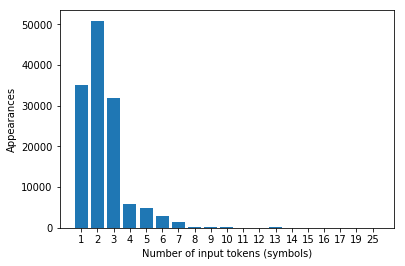

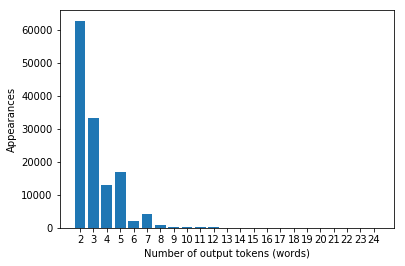

In [4]:
###############################################################################
# Review dataset by input and output length
###############################################################################
df0['input_length']  = df0['before'].apply(count_input_tokens) 
df0['output_length'] = df0['after'].apply(count_output_tokens) 
input_appearances_by_length = df0['input_length'].value_counts().sort_index()
output_appearances_by_length = df0['output_length'].value_counts().sort_index()
input_appearences_by_length  =  input_appearances_by_length.sort_index()
output_appearences_by_length = output_appearances_by_length.sort_index()

plt.clf()
plt.figure(1)
plt.bar(range(len(input_appearances_by_length)),input_appearances_by_length)
plt.xticks(range(len(input_appearances_by_length)), input_appearances_by_length.index)
plt.xlabel('Number of input tokens (symbols)')
plt.ylabel('Appearances')
#plt.yscale('log')
plt.show()

plt.figure(2)
plt.bar(range(len(output_appearences_by_length)),output_appearences_by_length)
plt.xticks(range(len(output_appearences_by_length)), output_appearences_by_length.index)
plt.xlabel('Number of output tokens (words)')
plt.ylabel('Appearances')
#plt.yscale('log')
plt.show()




In [5]:
import keras
from keras.models             import Sequential, Model
from keras.layers             import Dense, Dropout, TimeDistributed, Bidirectional, Input
from keras.layers             import Permute, Multiply, LSTM, Concatenate, Flatten
from keras.layers.core        import RepeatVector
from keras.callbacks          import ModelCheckpoint  

# New version of the encoder-decoder model, with internal memory instead of attention mechanism

encoder_units = 500
decoder_units = 500 

# TODO define input shape of vectorized sentences more precisely
# Note in the example of integer inputs, the shape was defined as: (pad_length,)
input_sentences_vectorized = Input(shape = input_shape, dtype='float32')

# Encode input symbols into a vector representation of specified dimension
# TODO may want to make encoder bi-directional
rnn_encoded, encoder_final_state_hidden, encoder_final_state_cell = LSTM(
        encoder_units, 
        return_sequences = False, 
        return_state     = True, 
        name             ='LSTM_encoder')(input_sentences_vectorized)

#rnn_encoded = Bidirectional(LSTM(encoder_units, return_sequences = True),
#                            name      ='bidirectional_LSTM_encoder',
#                            merge_mode='concat')(input_sentences_vectorized)

# Repeat encoded state vector so that decoder has access to it during each decoding step
# TODO ensure we pick the most relevant state of the encoder
encoder_final_states = keras.layers.Concatenate(axis=-1, name = 'Encoder_Final_States')([encoder_final_state_hidden, encoder_final_state_cell])
dropout_1 = Dropout(0.05, name = 'Dropout_1')(encoder_final_states)
encoded_repeated = RepeatVector(max_tokens_per_output_sentence, name = 'Repeat')(dropout_1)

decoder_vectors  = LSTM(
        decoder_units, 
        return_sequences=True, 
#        initial_state=[encoder_final_state_hidden, encoder_final_state_cell],
        name = 'Decoder')(encoded_repeated)

dropout_2 = Dropout(0.05, name = 'Dropout_2')(decoder_vectors)

output_token_probabilities = TimeDistributed(Dense(
        num_distinct_output_tokens, 
        activation = 'softmax', 
        name = 'Probabilities'))(dropout_2)

model = Model(input_sentences_vectorized, output_token_probabilities )
print(model.summary())

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 27)        0                                            
____________________________________________________________________________________________________
LSTM_encoder (LSTM)              [(None, 500), (None,  1056000     input_1[0][0]                    
____________________________________________________________________________________________________
Encoder_Final_States (Concatenat (None, 1000)          0           LSTM_encoder[0][1]               
                                                                   LSTM_encoder[0][2]               
____________________________________________________________________________________________________
Dropout_1 (Dropout)              (None, 1000)          0           Encoder_Final_States[0][

In [6]:
###############################################################################
# Prepare model optimization routine and fit the model
###############################################################################
np.random.seed(1234)

#default_sgd_optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Consider using keras.callbacks.LearningRateScheduler(schedule)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        if hasattr(self, 'loss') ==False:
            self.loss         = []
            self.val_loss     = []
            self.accuracy     = []
            self.val_accuracy = []
           #self.lr       = []
 
    def on_epoch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('weighted_acc'))
        self.val_accuracy.append(logs.get('val_weighted_acc'))
       #self.lr.append(step_decay(len(self.losses)))

global_loss_history = LossHistory()

In [7]:
###############################################################################
# Prepare model optimization routine and fit the model
###############################################################################
np.random.seed(1234)

#default_sgd_optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Consider using keras.callbacks.LearningRateScheduler(schedule)
       
#model.load_weights('saved_models/best.hdf5', by_name=False)
def compile_and_fit_the_model(
        initial_epoch    = 0,
        epochs           = 10,
        batch_size       = 64,
        verbose          = True,
        new_optimizer    = None,
        load_weights     = False,
        file_label       = 'best',
        filter_categories= {'CARDINAL'}
        ):
    
    df_train_subset = df_train
    df_val_subset   = df_val
    
    if len(filter_categories)>0:
        # TODO: Subset original data to provided filter, then re-index
        # This may allow the model to learn from simpler (smaller) datasets first
        type_match_new  = lambda type: type in filter_categories
        df_train_subset = df_train[df_train['class'].apply(type_match_new)==True].reset_index(drop=True)
        
        df_val_subset   = df_val[df_val['class'].apply(type_match_new)==True].reset_index(drop=True)

    subset_data_size_train = df_train_subset.shape[0]
    subset_data_size_val   = df_val_subset.shape[0]
    
    print ('Training on %i observations '%subset_data_size_train,
           '\nValidating on %i observations'%subset_data_size_val)
    
    #print(df_train_subset[-25:-1])
    #save_data_frame_to_Excel(df_train_subset[0:65530],'df_train_subset.xls')

    if new_optimizer: #compile optimization if new optimizer is provided
        model.compile(
            loss              = 'categorical_crossentropy', # reward ranking observed translations as likely
            optimizer         = new_optimizer, 
            sample_weight_mode= 'temporal',
            weighted_metrics  = ['accuracy'])    
    
    filename      = 'saved_models/' + file_label + '_epochs' + str(initial_epoch+1) +'_' + str(epochs) + '.hdf5'
    checkpointer1 = ModelCheckpoint(
            save_best_only= True,
            verbose       = 1, 
            filepath      = filename)
    if load_weights==True:
        print('Loading model weights...')
        model.load_weights(filename, by_name=False)    
        print('Done')
   
    model.fit_generator(
            generator           = training_data_generator(batch_size, df_train_subset, False), #input/output arrays
            validation_data     = validation_data_generator(batch_size, df_val_subset),
            epochs              = epochs,
            callbacks           = [checkpointer1, global_loss_history], 
            verbose             = verbose,
            steps_per_epoch     = int(subset_data_size_train/ batch_size),
            shuffle             = False,
            max_queue_size      = 64,
            validation_steps    = int(subset_data_size_val  / batch_size),
            initial_epoch       = initial_epoch
            )
    return 



from keras.optimizers import *

In [ ]:
compile_and_fit_the_model(epochs        = 1, 
                          initial_epoch = 0, 
                          batch_size    = 16, 
                          new_optimizer = 'rmsprop') 

Training on 66977 observations  
Validating on 33185 observations
Epoch 1/1
4186/4186 [==============================] - 12007s - loss: 0.6059 - weighted_acc: 0.8192 - val_loss: 0.2826 - val_weighted_acc: 0.9132


In [9]:
# Continue calibration with larger batch size and include learning rate
model.load_weights('saved_models/best_epochs1_1.hdf5')
compile_and_fit_the_model(epochs        = 10 , 
                          initial_epoch = 1  , 
                          batch_size    = 256, 
                          new_optimizer = RMSprop(lr=0.001, decay = 0.0001)) 
# Note default optimizers settings below:
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

Training on 66581 observations  
Validating on 33333 observations
Epoch 2/10
260/260 [==============================] - 1340s - loss: 0.1754 - weighted_acc: 0.9474 - val_loss: 0.1272 - val_weighted_acc: 0.9604
Epoch 3/10
260/260 [==============================] - 1339s - loss: 0.1234 - weighted_acc: 0.9625 - val_loss: 0.0909 - val_weighted_acc: 0.9719
Epoch 4/10
260/260 [==============================] - 1338s - loss: 0.0975 - weighted_acc: 0.9705 - val_loss: 0.0851 - val_weighted_acc: 0.9730
Epoch 5/10
260/260 [==============================] - 1338s - loss: 0.0794 - weighted_acc: 0.9754 - val_loss: 0.0678 - val_weighted_acc: 0.9784
Epoch 6/10
260/260 [==============================] - 1338s - loss: 0.0660 - weighted_acc: 0.9797 - val_loss: 0.0758 - val_weighted_acc: 0.9771
Epoch 7/10
260/260 [==============================] - 9418s - loss: 0.0594 - weighted_acc: 0.9821 - val_loss: 0.0579 - val_weighted_acc: 0.9820
Epoch 8/10
260/260 [==============================] - 14189s - loss: 0

KeyboardInterrupt: 

In [ ]:
#load best weights from previous calibration (note previously dropout layers were not used)
model.load_weights('saved_models/best_epochs2_10.hdf5', by_name = False)

#calibrate the model with smaller learning rate and keep decreasing it to ensure we make steps 
#right along the direction of a (stochastic) gradient
compile_and_fit_the_model(epochs        = 10 , 
                          initial_epoch = 9 , 
                          batch_size    = 256, 
                          new_optimizer = RMSprop(lr=0.0002, decay = 0.00001)) 

Training on 66581 observations  
Validating on 33333 observations
Epoch 10/20
260/260 [==============================] - 14246s - loss: 0.0312 - weighted_acc: 0.9912 - val_loss: 0.0445 - val_weighted_acc: 0.9863
Epoch 11/20


In [9]:
#load best weights from previous calibration (note previously dropout layers were not used)
model.load_weights('saved_models/best_epochs10_10.hdf5', by_name = False)

#calibrate the model with smaller learning rate and keep decreasing it to ensure we make steps 
#right along the direction of a (stochastic) gradient
compile_and_fit_the_model(epochs        = 12 , 
                          initial_epoch = 10 , 
                          batch_size    = 256, 
                          new_optimizer = RMSprop(lr=0.0002, decay = 0.00001)) 

Training on 66595 observations  
Validating on 33513 observations
Epoch 11/15
260/260 [==============================] - 9220s - loss: 0.0365 - weighted_acc: 0.9890 - val_loss: 0.0331 - val_weighted_acc: 0.9900
Epoch 12/15
260/260 [==============================] - 5226s - loss: 0.0302 - weighted_acc: 0.9912 - val_loss: 0.0323 - val_weighted_acc: 0.9904
Epoch 13/15
  9/260 [>.............................] - ETA: 1104s - loss: 0.0347 - weighted_acc: 0.9901

KeyboardInterrupt: 

In [9]:
#load best weights from previous calibration (note previously dropout layers were not used)
model.load_weights('saved_models/best_epochs11_12.hdf5', by_name = False)

#calibrate the model with smaller learning rate and keep decreasing it to ensure we make steps 
#right along the direction of a (stochastic) gradient
compile_and_fit_the_model(epochs        = 15 , 
                          initial_epoch = 12 , 
                          batch_size    = 256, 
                          new_optimizer = RMSprop(lr=0.0002, decay = 0.00001)) 

Training on 66565 observations  
Validating on 33515 observations
Epoch 13/15
260/260 [==============================] - 1335s - loss: 0.0303 - weighted_acc: 0.9910 - val_loss: 0.0293 - val_weighted_acc: 0.9914
Epoch 14/15
260/260 [==============================] - 1338s - loss: 0.0257 - weighted_acc: 0.9927 - val_loss: 0.0301 - val_weighted_acc: 0.9909
Epoch 15/15
260/260 [==============================] - 1341s - loss: 0.0224 - weighted_acc: 0.9940 - val_loss: 0.0290 - val_weighted_acc: 0.9914


In [ ]:
#load best weights from previous calibration (note previously dropout layers were not used)
#model.load_weights('saved_models/best_epochs13_15.hdf5', by_name = False)
model.load_weights('saved_models/best_epochs16_16.hdf5', by_name = False)

#calibrate the model with smaller learning rate and keep decreasing it to ensure we make steps 
#right along the direction of a (stochastic) gradient
#compile_and_fit_the_model(epochs        = 16 , 
#                          initial_epoch = 15 , 
#                          batch_size    = 256, 
#                          new_optimizer = RMSprop(lr=0.0002, decay = 0.00001)) 

compile_and_fit_the_model(epochs        = 20 , 
                          initial_epoch = 16 , 
                          batch_size    = 256, 
                          new_optimizer = RMSprop(lr=0.0002, decay = 0.00001)) 

compile_and_fit_the_model(epochs        = 50 , 
                          initial_epoch = 20 , 
                          batch_size    = 256,
                          new_optimizer = RMSprop(lr=0.00002, decay = 0.000001)
                         ) 

Training on 66565 observations  
Validating on 33515 observations
Epoch 17/20
206/260 [======================>.......] - ETA: 239s - loss: 0.0189 - weighted_acc: 0.9951

In [8]:
###############################################################################
# Inference mode (sampling).
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
#    and a "start of sequence" token as target.
#    Output will be the next target token
# 3) Append the target token and repeat
###############################################################################


def sort_and_plot(array_of_values = None, lookup_labels = None, top_N = 3):
    #plot 10 highest value elements in the dictionary
    
    dict1 = dict([(label, value)  for value, label in zip(array_of_values, lookup_labels)])
    #print(dict1)
    dict2 = dict(sorted(dict1.items(), key=itemgetter(1), reverse = True)[0:top_N])
    #print(dict2)
    elements_to_plot = min(top_N, len(dict2))
    ind = np.arange(elements_to_plot,0,-1)
    
    plt.clf()
    plt.barh(ind, list(dict2.values()))
    plt.yticks(ind, list(dict2.keys()))
    plt.show()
    return

#sort_and_plot([0.1, 0.5, 0.4], ['a','b','c'])

def decode_sequence(input_seq = None, graph_likely = True):
    # Encode the input as state vectors.
    #states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence for storing translated phrase
    target_seq = np.zeros((1, 1, num_distinct_output_tokens))
    
    # May want to later populate the first character of target sequence with the start character.
    #target_seq[0, 0, output_token_index['\t']] = 1.

    #print('Shape of model predictions is:', model.predict(input_seq).shape)
    output_tokens_scores = model.predict(input_seq)[0,:,:]
    #attention_flow       = attention_model.predict(input_seq)[0,:,:]
    #print(output_tokens_scores.shape)
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    number_of_words_in_translated_sentence = 0 

    #print(output_tokens_scores)

    while not stop_condition:
        # generate probability scores for each of the output tokens
        # based on decoder model applied to encoded state and target sequence
        #output_token_scores = decoder_model.predict([target_seq] + states_value)
        output_token_scores = output_tokens_scores[number_of_words_in_translated_sentence,:]
        
        #print('Probability scores for this token sum up to %i%%'%int(100*output_token_scores.sum()))
        
        #print('Next token scores', output_token_scores) 
        
        # Sample a token that has largest probability to appear next
        #sampled_token_index = np.argmax(output_token_scores[0, -1, :])
        sampled_token_index = np.argmax(output_token_scores)
        if graph_likely==True: sort_and_plot(output_token_scores, output_token_index)
        sampled_word = reverse_output_token_index[sampled_token_index]

        if number_of_words_in_translated_sentence > 0: decoded_sentence += ' '
            
        decoded_sentence += sampled_word        
        number_of_words_in_translated_sentence += 1
        
        # Exit condition: either hit max length or find stop character.
        if (sampled_word == '\n' or
           number_of_words_in_translated_sentence >= max_tokens_per_output_sentence):
            stop_condition = True

        # Add the sampled word to the sequence
        word_vector = np.zeros((1, 1, num_distinct_output_tokens))
        word_vector[0, 0, sampled_token_index] = 1.
        
#        print ('Best guess token: ', sampled_word, 
#               ' with associated score ', np.max(output_token_scores))

        target_seq = np.concatenate([target_seq, word_vector], axis=1)
                
    #print ('target sequence: ',target_seq)

    return decoded_sentence


###############################################################################
# Prepare functionality to translate input sentence
#   1) vectorize sentence using one-hot encoding for each input symbol
#   2) feed vectorized sentence into the model
#   3) run step-by-step translation by picking most likely token at each step
###############################################################################
def vectorize(sentence):
    # initialize decoder input data as 3D NumPy array of zeroes with dimensions:
    # 1) 1
    # 2) maximum sentence length for decoder
    # 3) number of decoder tokens (destination language)
    vectorized_sentence = np.zeros(
        (1, max_tokens_per_input_sentence, num_distinct_input_tokens),
        dtype='bool')
    
    # fill in encoder input  data representing characters via one-hot encoding
    for t, char in enumerate(sentence):
        if t < max_tokens_per_input_sentence:
            vectorized_sentence[0, t, input_token_index[char]] = 1.
       
    #print('Vectorized sentence has %i tokens'%vectorized_sentence.sum())
    return vectorized_sentence

def translate(sentence = None, graph_likely = False):
    #vectorized_sentence = vectorize('\t' + sentence) 
    vectorized_sentence = vectorize(sentence.lower()) 
    #print('Number of symbols in vectorized sentence is %i: '%vectorized_sentence.sum())
    decoded = decode_sequence(vectorized_sentence, graph_likely)
    if decoded[-2:] == ' \n': decoded = decoded[0:-2] #omit end token
    #print (decoded)
    return decoded   


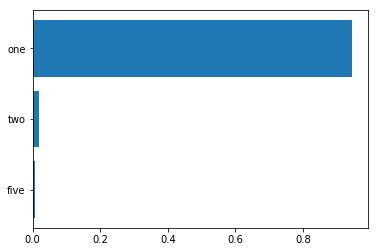

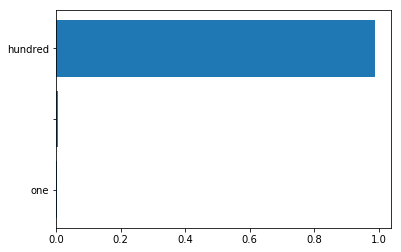

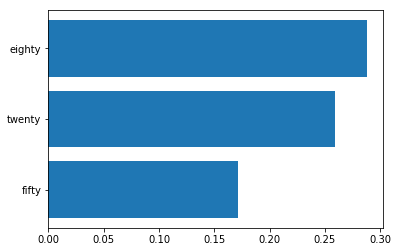

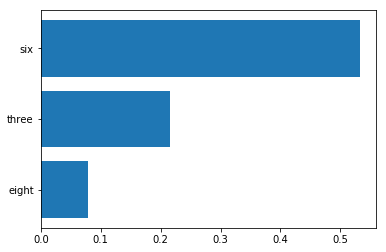

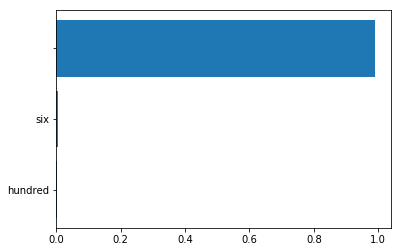

'one hundred eighty six'

In [30]:
#model.load_weights('saved_models/best_epochs2_10.hdf5') # works well on -999,999
#model.load_weights('saved_models/best_epochs10_10.hdf5') 
#model.load_weights('saved_models/best_epochs11_12.hdf5', by_name = False)
model.load_weights('saved_models/best_epochs13_15.hdf5', by_name = False)
#model.load_weights('saved_models/best_epochs16_16.hdf5', by_name = False)

# Test translation mechanism
#translate('911')
#translate('X')
#translate('1003', True)
#translate('1')
#translate('2')
#translate('23', True)
#translate('5')
#translate('asdasda ')
#translate('100', True)

#translate('12', True)
#translate('LXXXVIII', True)
translate('CLXXXIII', True)

#translate('-999,999')
#translate('LXXXVIII')
#translate('20151956')
#translate('-742,791', True)

#translate('-742,791', True)

In [24]:
#list(output_token_index.values())

In [33]:
###############################################################################
# Visualize model performance over time (weighted accuracy, loss)
###############################################################################
def plot_training_history(
        data      = None, 
        x_axis_name = 'epoch',
        y_axis_name = 'categorical cross-entropy loss',
        y_limit_bottom = 0
        ):
    for metric_name, series in data.items():
        plt.plot(range(len(series)), series, label = metric_name)
    
    plt.legend(loc=1)
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    if y_limit_bottom: plt.gca().set_ylim(bottom=0)
    plt.show()


#plot_training_history({'training': global_loss_history.loss, 'validation':  global_loss_history.val_loss}) 
#plot_training_history( {'training': global_loss_history.accuracy, 'validation':  global_loss_history.val_accuracy},
#                     y_axis_name = 'weighted accuracy', y_limit_bottom = None)

In [28]:
###############################################################################
# Evaluate accuracy of translation on the modeling and testing data
# Define function to evaluate accuracy on the dataset provided
# 1) execute translation
# 2) evaluate accuracy
###############################################################################

#model.load_weights('saved_models/best_epochs2_10.hdf5')
#model.load_weights('saved_models/best_epochs13_15.hdf5')

from pandas import ExcelWriter
def save_data_frame_to_Excel(dataset, save_data_to = 'saved.xls'):
    writer = pd.ExcelWriter(save_data_to)
    sheet_name = 'Sheet1'
    dataset.to_excel(writer,sheet_name)
    writer.save()
    return

translation_process = lambda sentence: translate(sentence)

def translate_dataset(dataset = None, save_data_to = 'translated.xlsx', append = False):        
    #print(dataset['before'])
    dataset['translated']       = dataset['before'].apply(translation_process)
    dataset['match']            = dataset['translated'] == dataset['after']
    dataset['max_token_length'] = dataset['before'].apply(count_input_tokens)    
    
    number_of_phrases = dataset.shape[0]
    number_of_phrases_correctly_tranlsated = dataset.loc[dataset['translated'] == dataset['after']].shape[0]
    translation_accuracy = number_of_phrases_correctly_tranlsated / number_of_phrases 
    print('Translation accuracy: %4f'%translation_accuracy)
    
    #dataset.to_csv(save_data_to)
    save_data_frame_to_Excel(dataset, save_data_to)
    return

translate_dataset(df_test, save_data_to = 'test_translated_Nov15_benchmark.xls')

Translation accuracy: 0.986103


In [ ]:
# save global calibration history to file
import pickle
f = open('global_loss_history.file','wb')
pickle.dump(global_loss_history, f )
f.close()
#global_loss_history = pickle.load('global_loss_history.file')